# Arpan's AI Skill Showcase



This notebook is for the WAT AI Skill Showcase.

In [46]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import copy

# Set up matplotlib for inline plotting
%matplotlib inline

# Check if CUDA is available. Won't be for me since I am on an M1 chip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set image size for consistent processing
imsize = 256 if torch.cuda.is_available() else 128  # Use smaller size if no GPU so its faster

print(f"Image processing size: {imsize}x{imsize}")


Using device: cpu
Image processing size: 128x128


In [30]:
# Define image loading and preprocessing functions
def load_image_from_file(filepath, size=None):
    """Load an image from local file and preprocess it"""
    image = Image.open(filepath).convert('RGB')
    
    if size is None:
        size = imsize
        
    # Resize image
    image = image.resize((size, size))
    
    return np.array(image)

def display_image(image_array, title=None):
    # Display a numpy array as an image
    plt.imshow(image_array)
    if title is not None:
        plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')

def simple_kmeans(data, k=8, max_iters=50):
    # For simplicity, we just use a simple k-mean implementation using numpy
    # Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iters):
        # Assign points to nearest centroid
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        
        # Update centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    
    return labels, centroids


Content image shape: (128, 128, 3)
Style image shape: (128, 128, 3)


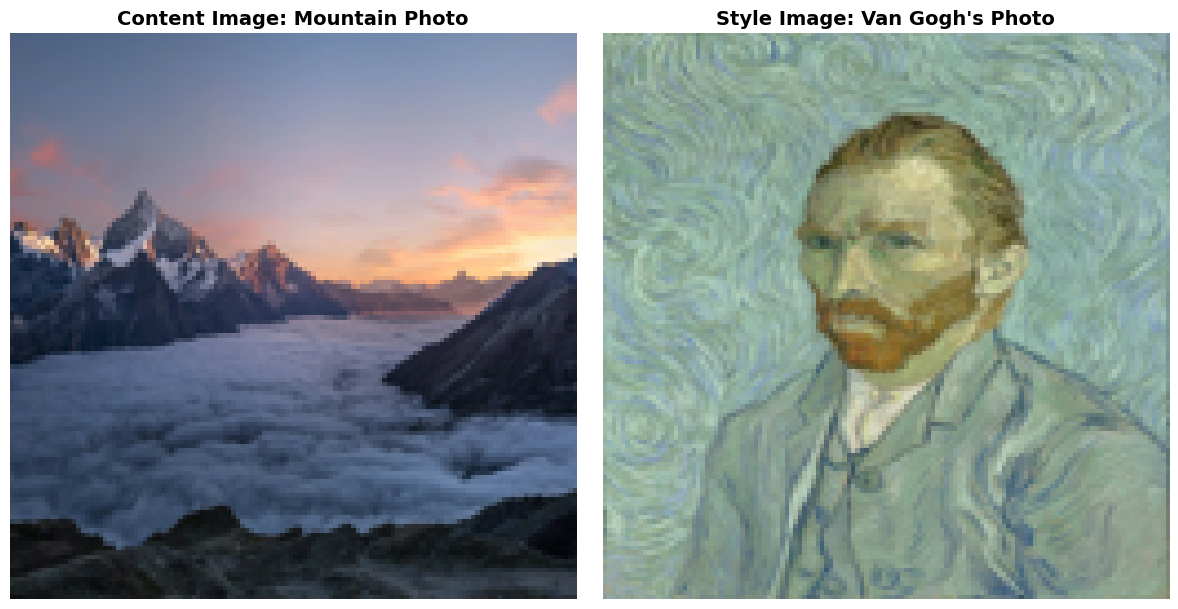

In [47]:
# Load content and style images from local files
# Used local files for the showcase so that code is reproducible in case of url changes/issues

# mountain photo
content_path = "images/content_landscape.jpg"

# van gogh's starry night
style_path = "images/van_gogh_photo.jpg"

# Load images from paths
content_img = load_image_from_file(content_path)
style_img = load_image_from_file(style_path)

# Display the shape of the iamges which should be the same
print(f"Content image shape: {content_img.shape}")
print(f"Style image shape: {style_img.shape}")

# Display the original images for a before compariosn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
display_image(content_img, title='Content Image: Mountain Photo')

plt.subplot(1, 2, 2)
display_image(style_img, title='Style Image: Van Gogh\'s Photo')

plt.tight_layout()
plt.show()



After loading the photos, we will use k-mean clustering to extract dominant colours and/or styles

In [37]:
# Prepare image data for analysis

# Convert images by flattening the 2D image array into a 1D array of pixels
content_data = content_img.reshape(-1, 3)  # Flatten to (pixels, 3)
style_data = style_img.reshape(-1, 3)

# Shape of data should be the same
print(f"Content image data shape: {content_data.shape}")
print(f"Style image data shape: {style_data.shape}")

# Convert to PyTorch tensors so it's easeier to work with
content_tensor = torch.from_numpy(content_data).float()
style_tensor = torch.from_numpy(style_data).float()


Content image data shape: (16384, 3)
Style image data shape: (16384, 3)


In [39]:
# Extract dominant colors from both images using k-mean clustering
n_colors = 8  # Number of dominant colors to extract, can be changed to any number

# Set standard random seed 
np.random.seed(42)

# K-Means on content image to cluster the pixels into n_colors
content_labels, content_colors = simple_kmeans(content_data, k=n_colors)

# K-Means on style image to cluster the pixels into n_colors
style_labels, style_colors = simple_kmeans(style_data, k=n_colors)

print(f"{n_colors} dominant colors from each image")


8 dominant colors from each image


In [ ]:
# Create quantized images using K-means results
def create_quantized_image(original_shape, labels, colors):
    """Recreate image using only the dominant colors"""
    quantized = colors[labels]
    return quantized.reshape(original_shape).astype(np.uint8)

content_quantized = create_quantized_image(content_img.shape, content_labels, content_colors)
style_quantized = create_quantized_image(style_img.shape, style_labels, style_colors)

Content image - Mean RGB: [ 98.9657  101.33368 118.33038]
Content image - Std RGB: [62.590202 50.878338 49.873154]
Style image - Mean RGB: [137.34656 159.22693 142.56982]
Style image - Std RGB: [19.308882 22.313663 27.948423]


In [41]:
# Create a hybrid image by blending color palettes  

def blend_color_palettes(img1, img2, labels1, labels2, colors1, colors2, blend_ratio=0.7):
    """Create a hybrid image by blending color palettes"""
    # Blend the color palettes
    blended_colors = blend_ratio * colors1 + (1 - blend_ratio) * colors2
    
    # Create hybrid image using content structure with blended colors
    hybrid = blended_colors[labels1]
    return hybrid.reshape(img1.shape).astype(np.uint8)

# Create hybrid image (70% content colors, 30% style colors)
hybrid_img = blend_color_palettes(content_img, style_img, 
                                content_labels, style_labels,
                                content_colors, style_colors, 
                                blend_ratio=0.7)


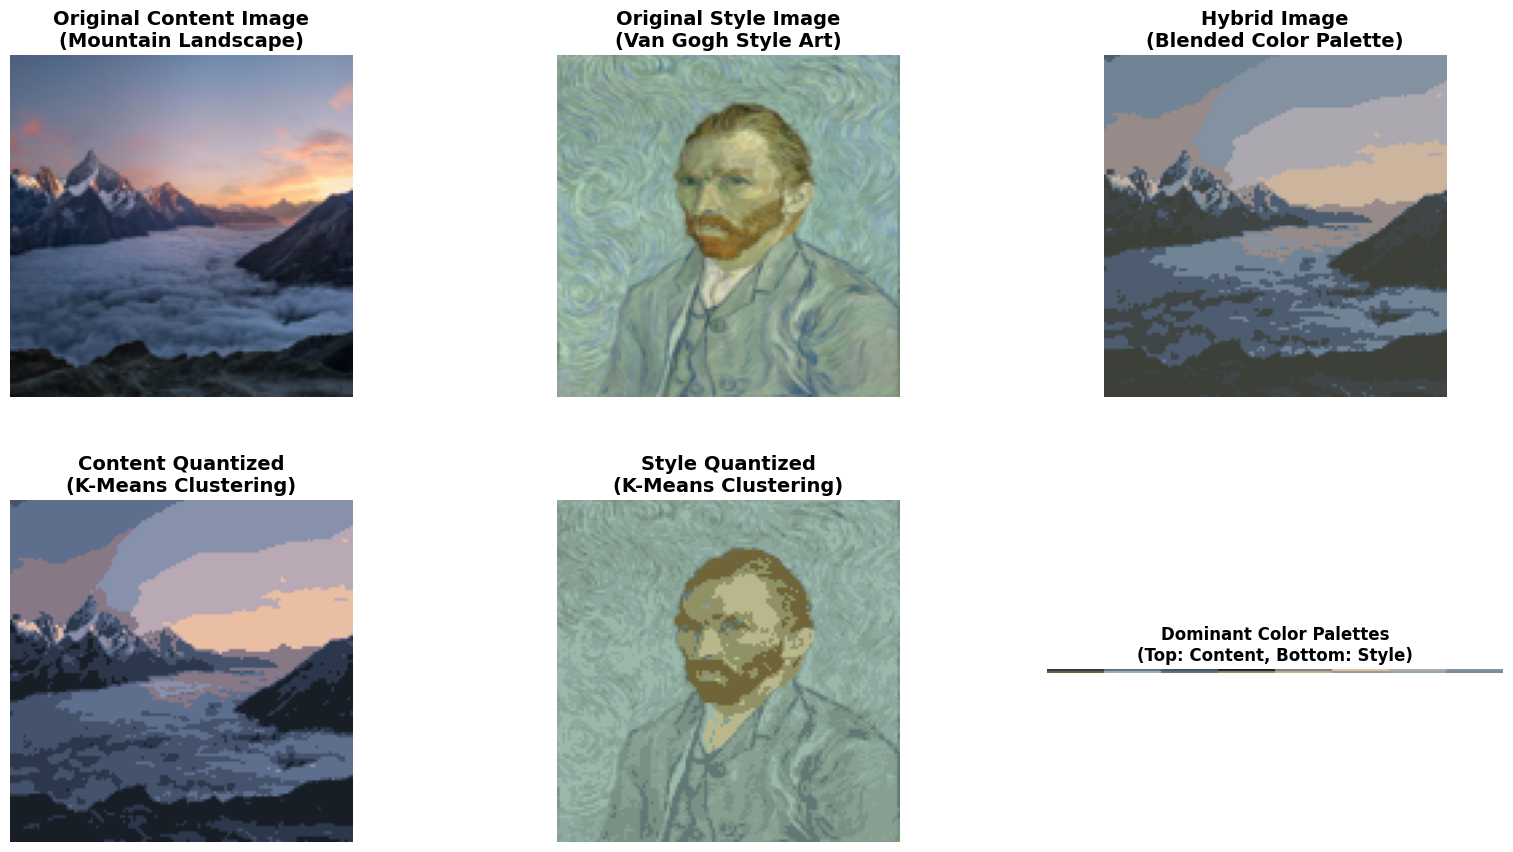

In [45]:
# Display the results, including the original imags, quantized images, color palettes and hybrid image
fig = plt.figure(figsize=(20, 16))

# Create a 3x3 grid for images and analysis
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.2)

# Row 1: Original Images
ax1 = fig.add_subplot(gs[0, 0])
plt.sca(ax1)
display_image(content_img, title='Original Content Image\n(Mountain Landscape)')

ax2 = fig.add_subplot(gs[0, 1])
plt.sca(ax2)
display_image(style_img, title='Original Style Image\n(Van Gogh Style Art)')

# Row 1: Hybrid Result
ax3 = fig.add_subplot(gs[0, 2])
plt.sca(ax3)
display_image(hybrid_img, title='Hybrid Image\n(Blended Color Palette)')

# Row 2: Color-Quantized Images
ax4 = fig.add_subplot(gs[1, 0])
plt.sca(ax4)
display_image(content_quantized, title='Content Quantized\n(K-Means Clustering)')

ax5 = fig.add_subplot(gs[1, 1])
plt.sca(ax5)
display_image(style_quantized, title='Style Quantized\n(K-Means Clustering)')

# Row 2: Color Palettes
ax6 = fig.add_subplot(gs[1, 2])
plt.sca(ax6)
# Create color palette visualization
palette_img = np.array([content_colors, style_colors])
palette_img = np.repeat(palette_img, 30, axis=1).astype(np.uint8)
plt.imshow(palette_img)
plt.title('Dominant Color Palettes\n(Top: Content, Bottom: Style)', fontweight='bold')
plt.axis('off')

plt.show()
